# Fasttext Supervised learning example 

This notebook is inspired by the [Supervised Learning fastText tutorial](https://github.com/facebookresearch/fastText/blob/master/tutorials/supervised-learning.md)

In [3]:
import fastText as ft
from fastText import train_supervised
from string import punctuation
from nltk.corpus import stopwords
from itertools import islice
from os import path
import numpy as np
import matplotlib.pyplot as plt
from models import *
%matplotlib inline

In [4]:
def read_data(filename):
    """
    Read data 'line by line', using generators.
    Generators make it easier to process BIG text files.
    """
    with open(filename, 'r') as input:
        for line in input:
            yield line

In [5]:
def write_data(filename, data):
    """
    Write result to a file.
    
    :param result: the list to be written to the file
    """
    with open(filename, "a") as output:
        output.write('{}\n'.format(data))

In [6]:
def preprocess_(data):
    """
    Preprocess data, filtering out stopwords, punctuation and lowering 
    all splitted tokens.
    
    :param data: the string data to be processed
    """    
    # Pad punctuation with spaces on both sides
    for char in ['.', '"', ',', '(', ')', '!', '?', ';', ':']:
        data = data.replace(char, ' ' + char + ' ')
    sw = stopwords.words('english')
    splitted_chunks = data.split()
    lowered_chunks = (item.lower() for item in splitted_chunks)
    chunks_without_punctuation = (chunk for chunk in lowered_chunks if chunk not in punctuation)
    chunks_without_stopwords = (chunk for chunk in chunks_without_punctuation if chunk not in sw)
    return " ".join(list(chunks_without_stopwords))

In [7]:
def pipeline(input_filename, output_filename, limit=None):
    """
    Iterate over the rows and apply the text preprocessing.

    :param input_filename: name of the input filename
    :param output_filename: name of the output filename
    :param limit: get the first N rows
    """    
    open(output_filename, 'w').close()  # Hack to "reset" the output file
    for row in islice(read_data(input_filename), 0, limit):
        data = preprocess_(row)
        if data:
            write_data(output_filename, data)

In [8]:
def test_model(model, test_data):
    result = model.test(test_data)
    print('Precision@1:', result.precision)
    print('Recall@1:', result.recall)
    print('Number of examples:', result.nexamples)

In [9]:
def fastText_split(df, split, directory):
    train, dev, test = split_dataframe(df, split)
    fasttext_formatter(train, "temp_train.txt")
    pipeline("temp_train.txt", directory+"train.txt")
    fasttext_formatter(dev, "temp_dev.txt")
    pipeline("temp_dev.txt", directory+"dev.txt")
    fasttext_formatter(test, "temp_test.txt")
    pipeline("temp_test.txt", directory+"test.txt")
    

In [10]:
def get_sent_df(df):
    contents = []
    texts = []
    labels = []
    sentences = df.content.str.split(".")
    for i in range(len(df)):
        label = df.gender.iloc[i]
        email = sentences.iloc[i]
        for j in range(len(email)):
            sentence = email[j]
            text = preprocess_(email[j])
            if text == "":
                pass
            else:
                contents.append(sentence)
                texts.append(text)
                labels.append(label)
    
    return pd.DataFrame(np.array([texts, texts, labels]).T, columns = ["content", "text", "gender"])


def get_word_df(df):
    contents = []
    texts = []
    labels = []
    sentences = df.content.str.split(" ")
    for i in range(len(df)):
        label = df.gender.iloc[i]
        email = sentences.iloc[i]
        for j in range(len(email)):
            sentence = email[j]
            text = preprocess_(email[j])
            if text == "":
                pass
            else:
                contents.append(sentence)
                texts.append(text)
                labels.append(label)
    
    return pd.DataFrame(np.array([contents, texts, labels]).T, columns = ["content", "text", "gender"])


def get_df_dict(filename, prime_dir):
    mail_df = preprocess(filename)
    mail_df["text"] = mail_df.content.apply(preprocess_)
    mail_splits = get_splits(mail_df)
    fastText_split(mail_df, mail_splits, prime_dir+"email/")
    sent_df = get_sent_df(mail_df)
    sent_splits =  get_splits(sent_df)
    fastText_split(sent_df, sent_splits, prime_dir+"sentence/")
    word_df = get_word_df(sent_df)
    word_splits =  get_splits(word_df)
    fastText_split(word_df, word_splits, prime_dir+"word/")
    df_dict = {"email":{"df":{"train":mail_df.iloc[mail_splits[0]],
                              "dev":mail_df.iloc[mail_splits[1]],
                              "test":mail_df.iloc[mail_splits[2]]},
                        "train":prime_dir+"email/train.txt",
                        "dev":prime_dir+"email/dev.txt",
                        "test":prime_dir+"email/test.txt"},
               "sentence": {"df":{"train":sent_df.iloc[sent_splits[0]],
                                  "dev":sent_df.iloc[sent_splits[1]],
                                  "test":sent_df.iloc[sent_splits[2]]},
                            "train":prime_dir+"sentence/train.txt",
                            "dev":prime_dir+"sentence/dev.txt",
                            "test":prime_dir+"sentence/test.txt"},
               "word": {"df":{"train":word_df.iloc[word_splits[0]],
                              "dev":word_df.iloc[word_splits[1]],
                              "test":word_df.iloc[word_splits[2]]},
                        "train":prime_dir+"word/train.txt",
                        "dev":prime_dir+"word/dev.txt",
                        "test":prime_dir+"word/test.txt"}}
    return df_dict

def update_df_dict(filename, df_dict):
    f = open(filename)
    lines = [line.strip() for line in f.readlines()]
    f.close()
    genders = [line.split(" ")[0][9] for line in lines]
    content = [" ".join(line.split(" ")[1:]) for line in lines]
    data = np.array([content, genders]).T
    mail_df = pd.DataFrame(data, columns = ["content", "gender"])
    mail_df["text"] = mail_df.content.apply(preprocess_)
    #mail.to_csv("temp.csv")
    #mail_df = preprocess("temp.csv")
    sent_df = get_sent_df(mail_df)
    word_df = get_word_df(sent_df)
    df_dict["email"]["df"]["fairframe"] = mail_df
    df_dict["sentence"]["df"]["fairframe"] = sent_df
    df_dict["word"]["df"]["fairframe"] = word_df
    return df_dict

In [11]:
senders = get_df_dict("sender_data.csv", "fastText_data/sender/")
recipients = get_df_dict("recipient_data.csv", "fastText_data/recipient/")

In [12]:
senders = update_df_dict("fastText_data/author_FairFrame.txt",senders)
recipients = update_df_dict("fastText_data/recipient_FairFrame.txt" ,recipients)

In [11]:


data_dir = path.join(path.dirname("__file__"), 'data')
enron_input = path.join(data_dir, 'recipient_data.txt')
fairframe_test = path.join(data_dir, 'fairframe.train') 


In [12]:
#pipeline(cooking_input, cooking_input_norm)

### Using fasttext

In [13]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

In [14]:
def results(N, p, r):
    return N, p, r
    

In [15]:

# Info to save the model
model_dir = path.join(path.dirname("__file__"), 'models')
gender_output = path.join(model_dir, 'gender_classification')

In [18]:
def get_F1(p, r):
    return(2.0/((p**-1)+(r**-1)))
def get_acc(model, df):
    
    pred = df.text.apply(lambda x: model.predict(x)[0][0][9].capitalize())
    return sum(pred==df.gender)/len(df)

# Senders: Email Level

(3, 3)

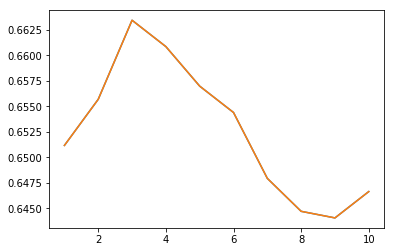

In [19]:
N_val = []
precision = []
recall = []
f1 = []
accs = []
param_range = list(range(1,11))
sender_val = senders["email"]["df"]["dev"]
for count in param_range:
    model = train_supervised(input=senders["email"]["train"], 
                             epoch=50, #tuned 
                             lr=10.0**-1, #tuned minimal improvements
                             ws = 5, #default 5
                             wordNgrams=count, #tuned 5
                             verbose=2, #default 2
                             minCount=1, #default 1 
                             dim=200)
    N,p,r =  results(*model.test(senders["email"]["dev"]))
    f1.append(get_F1(p,r))
    N_val.append(N)
    precision.append(p)
    recall.append(r)
    accs.append(get_acc(model, sender_val))




plt.plot(param_range,f1)
plt.plot(param_range, accs)
param_range[np.argmax(f1)], param_range[np.argmax(accs)]


(-2, -2)

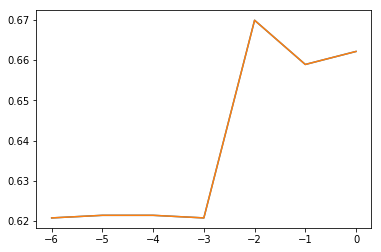

In [20]:
N_val = []
precision = []
recall = []
f1 = []
accs = []
param_range = np.arange(-6,1)
sender_val = senders["email"]["df"]["dev"]
for rate in 10.0**param_range:
    model = train_supervised(input=senders["email"]["train"], 
                             epoch=50, #tuned 
                             lr=rate, #tuned minimal improvements
                             ws = 5, #default 5
                             wordNgrams=2, #tuned 
                             verbose=2, #default 2
                             minCount=1, #default 1 
                             dim=200)
    N,p,r =  results(*model.test(senders["email"]["dev"]))
    f1.append(get_F1(p,r))
    N_val.append(N)
    precision.append(p)
    recall.append(r)
    accs.append(get_acc(model, sender_val))


plt.plot(param_range,f1)
plt.plot(param_range, accs)
param_range[np.argmax(f1)], param_range[np.argmax(accs)]

In [21]:
#best model for sender
sender_test = senders["email"]["df"]["test"]
sender_val = senders["email"]["df"]["dev"]
senders["email"]["model"] = train_supervised(input=senders["email"]["train"], 
                             epoch=50, #tuned 
                             lr=10.0**-1, #tuned minimal improvements
                             ws = 5, #tuned 
                             wordNgrams=1, #tuned 
                             verbose=2, #tuned minimal improvements
                             minCount=1, 
                             dim=200)
print(get_acc(senders["email"]["model"], sender_test), get_acc(senders["email"]["model"], sender_val))
#insert model tested on fair frame here

0.6658056183403294 0.6556847545219638


# Sender: Sentence Level

(1, 1)

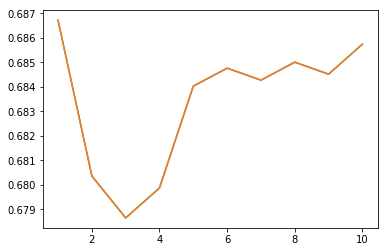

In [22]:
N_val = []
precision = []
recall = []
f1 = []
accs = []
param_range = list(range(1,11))
sender_val = senders["sentence"]["df"]["dev"]
for count in param_range:
    model = train_supervised(input=senders["sentence"]["train"], 
                             epoch=50, #tuned 
                             lr=10.0**-2, #tuned minimal improvements
                             ws = 5, #default 5
                             wordNgrams=count, #tuned 5
                             verbose=2, #default 2
                             minCount=1, #default 1 
                             dim=200)
    N,p,r =  results(*model.test(senders["sentence"]["dev"]))
    f1.append(get_F1(p,r))
    N_val.append(N)
    precision.append(p)
    recall.append(r)
    accs.append(get_acc(model, sender_val))




plt.plot(param_range,f1)
plt.plot(param_range, accs)
param_range[np.argmax(f1)], param_range[np.argmax(accs)]

(-3, -3)

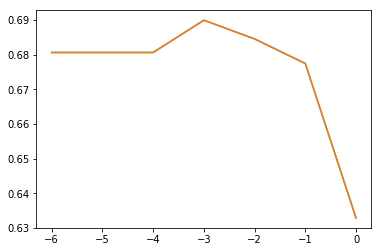

In [23]:
N_val = []
precision = []
recall = []
f1 = []
accs = []
param_range = np.arange(-6,1)
sender_val = senders["sentence"]["df"]["dev"]
for rate in 10.0**param_range:
    model = train_supervised(input=senders["sentence"]["train"],
                             epoch=50, #tuned 
                             lr=rate, #tuned minimal improvements
                             ws = 5, #default 5
                             wordNgrams=1, #tuned 
                             verbose=2, #default 2
                             minCount=1, #default 1
                             dim=200)
    N,p,r =  results(*model.test(senders["sentence"]["dev"]))
    f1.append(get_F1(p,r))
    N_val.append(N)
    precision.append(p)
    recall.append(r)
    accs.append(get_acc(model, sender_val))


plt.plot(param_range,f1)
plt.plot(param_range, accs)
param_range[np.argmax(f1)], param_range[np.argmax(accs)]

In [24]:
#best model for sender
sender_test = senders["sentence"]["df"]["test"]
sender_val = senders["sentence"]["df"]["dev"]
senders["sentence"]["model"] = train_supervised(input=senders["sentence"]["train"], 
                             epoch=50, #tuned 
                             lr=10.0**-2, #tuned minimal improvements
                             ws = 5, #tuned 
                             wordNgrams=1, #tuned 
                             verbose=2, #tuned minimal improvements
                             minCount=1, 
                             dim=200)
print(get_acc(senders["sentence"]["model"], sender_test), get_acc(senders["sentence"]["model"], sender_val))
#insert model tested on fair frame here

0.6834514788560254 0.6850085595500123


# Sender: Word Level

(8, 8)

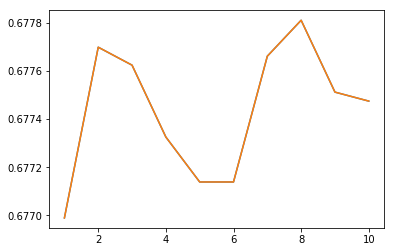

In [35]:
N_val = []
precision = []
recall = []
f1 = []
accs = []
param_range = list(range(1,11))
sender_val = senders["word"]["df"]["dev"]
for count in param_range:
    model = train_supervised(input=senders["word"]["train"], 
                             epoch=50, #tuned 
                             lr=10.0**-2, #tuned minimal improvements
                             ws = 5, #default 5
                             wordNgrams=count, #tuned 6
                             verbose=2, #default 2
                             minCount=1, #default 1 
                             dim=200)
    N,p,r =  results(*model.test(senders["word"]["dev"]))
    f1.append(get_F1(p,r))
    N_val.append(N)
    precision.append(p)
    recall.append(r)
    accs.append(get_acc(model, sender_val))




plt.plot(param_range,f1)
plt.plot(param_range, accs)
param_range[np.argmax(f1)], param_range[np.argmax(accs)]

(-2, -2)

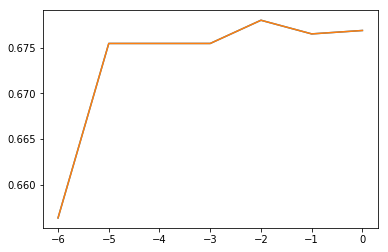

In [26]:
N_val = []
precision = []
recall = []
f1 = []
accs = []
param_range = np.arange(-6,1)
sender_val = senders["word"]["df"]["dev"]
for rate in 10.0**param_range:
    model = train_supervised(input=senders["word"]["train"], 
                             epoch=50, #tuned 
                             lr=rate, #tuned minimal improvements
                             ws = 1, #tuned 
                             wordNgrams=1, #tuned 
                             verbose=1, #tuned minimal improvements
                             minCount=1, 
                             dim=1)
    N,p,r =  results(*model.test(senders["word"]["dev"]))
    f1.append(get_F1(p,r))
    N_val.append(N)
    precision.append(p)
    recall.append(r)
    accs.append(get_acc(model, sender_val))


plt.plot(param_range,f1)
plt.plot(param_range, accs)
param_range[np.argmax(f1)], param_range[np.argmax(accs)]

In [27]:
#best model for sender
sender_test = senders["word"]["df"]["test"]
sender_val = senders["word"]["df"]["dev"]
senders["word"]["model"] = train_supervised(input=senders["word"]["train"], 
                             epoch=50, #tuned 
                             lr=10.0**-2, #tuned minimal improvements
                             ws = 5, #tuned 
                             wordNgrams=1, #tuned 
                             verbose=2, #tuned minimal improvements
                             minCount=1, 
                             dim=200)
print(get_acc(senders["word"]["model"], sender_test), get_acc(senders["word"]["model"], sender_val))
#insert model tested on fair frame here

0.6728977198453753 0.6766903249906612


# Recipients

5

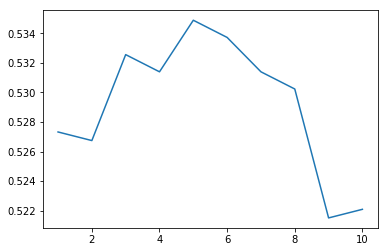

In [28]:
N_val = []
precision = []
recall = []
f1 = []
accs = []
param_range = list(range(1,11))
recipient_val = recipients["email"]["df"]["dev"]
for count in param_range:
    model = train_supervised(input=recipients["email"]["train"], 
                             epoch=50, #tuned 
                             lr=10.0**-2, #tuned minimal improvements
                             ws = 5, #default 5
                             wordNgrams=count, #tuned 1
                             verbose=2, #default 2
                             minCount=1, #default 1
                             dim=200)
    N,p,r =  results(*model.test(recipients["email"]["dev"]))
    f1.append(get_F1(p,r))
    N_val.append(N)
    precision.append(p)
    recall.append(r)
    accs.append(get_acc(model, recipient_val))




plt.plot(param_range,f1)
param_range[np.argmax(f1)]

-2

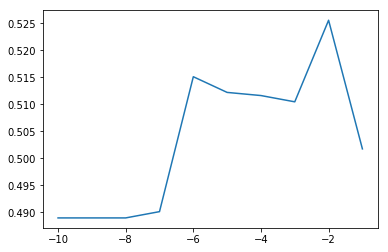

In [29]:
N_val = []
precision = []
recall = []
f1 = []
accs = []
param_range = np.arange(-10,0)
recipient_val = recipients["email"]["df"]["dev"]
for rate in 10.0**param_range:
    model = train_supervised(input=recipients["email"]["train"], 
                             epoch=50, #tuned 
                             lr=rate, #tuned minimal improvements
                             ws = 5, #tuned 
                             wordNgrams=2, #tuned 
                             verbose=2, #tuned minimal improvements
                             minCount=1, 
                             dim=200)
    N,p,r =  results(*model.test(recipients["email"]["dev"]))
    f1.append(get_F1(p,r))
    N_val.append(N)
    precision.append(p)
    recall.append(r)
    accs.append(get_acc(model, recipient_val))

plt.plot(param_range,f1)
param_range[np.argmax(f1)]

In [30]:
#Best model for recipient
recipient_test = recipients["email"]["df"]["test"]
recipient_val = recipients["email"]["df"]["dev"]
recipients["email"]["model"] = train_supervised(input=recipients["email"]["train"], 
                             epoch=50, #tuned 
                             lr=10.0**-2, #tuned minimal improvements
                             ws = 5, #tuned 
                             wordNgrams=1, #tuned 
                             verbose=2, #tuned minimal improvements
                             minCount=1, 
                             dim=200)

print(get_acc(recipients["email"]["model"], recipient_test), get_acc(recipients["email"]["model"], recipient_val))
#insert model tested on fair frame here

0.5222319093286836 0.5284883720930232


# Recipient: Sentence Level

(2, 2)

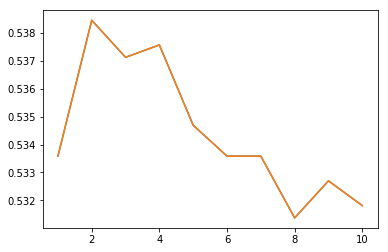

In [31]:
N_val = []
precision = []
recall = []
f1 = []
accs = []
param_range = list(range(1,11))
recipient_val = recipients["sentence"]["df"]["dev"]
for count in param_range:
    model = train_supervised(input=recipients["sentence"]["train"], 
                             epoch=50, #tuned 
                             lr=10.0**-2, #tuned minimal improvements
                             ws = 5, #default 5
                             wordNgrams=count, #tuned 1
                             verbose=2, #default 2
                             minCount=1, #default 1 
                             dim=200)
    N,p,r =  results(*model.test(recipients["sentence"]["dev"]))
    f1.append(get_F1(p,r))
    N_val.append(N)
    precision.append(p)
    recall.append(r)
    accs.append(get_acc(model, recipient_val))




plt.plot(param_range,f1)
plt.plot(param_range, accs)
param_range[np.argmax(f1)], param_range[np.argmax(accs)]

(-2, -2)

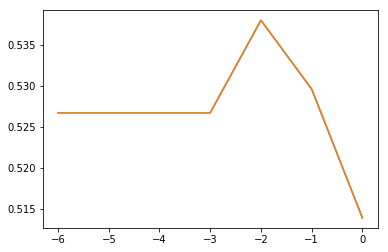

In [32]:
N_val = []
precision = []
recall = []
f1 = []
accs = []
param_range = np.arange(-6,1)
recipient_val = recipients["sentence"]["df"]["dev"]
for rate in 10.0**param_range:
    model = train_supervised(input=recipients["sentence"]["train"],
                             epoch=50, #tuned 
                             lr=rate, #tuned minimal improvements
                             ws = 1, #tuned 
                             wordNgrams=1, #tuned 
                             verbose=1, #tuned minimal improvements
                             minCount=1, 
                             dim=200)
    N,p,r =  results(*model.test(recipients["sentence"]["dev"]))
    f1.append(get_F1(p,r))
    N_val.append(N)
    precision.append(p)
    recall.append(r)
    accs.append(get_acc(model, recipient_val))


plt.plot(param_range,f1)
plt.plot(param_range, accs)
param_range[np.argmax(f1)], param_range[np.argmax(accs)]

In [33]:
#best model for sender
recipient_test = recipients["sentence"]["df"]["test"]
recipient_val = recipients["sentence"]["df"]["dev"]
recipients["sentence"]["model"] = train_supervised(input=recipients["sentence"]["train"], 
                             epoch=50, #tuned 
                             lr=10.0**-2, #tuned minimal improvements
                             ws = 1, #tuned 
                             wordNgrams=1, #tuned 
                             verbose=1, #tuned minimal improvements
                             minCount=1, 
                             dim=200)
print(get_acc(recipients["sentence"]["model"], recipient_test), get_acc(recipients["sentence"]["model"], recipient_val))
#insert model tested on fair frame here

0.5232468249585864 0.541095890410959


# Recipient: Word Level

(1, 1)

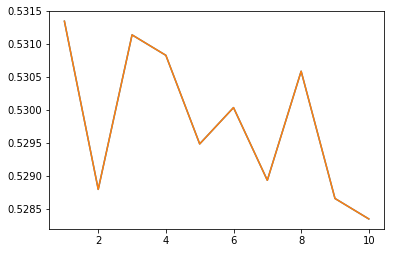

In [34]:
N_val = []
precision = []
recall = []
f1 = []
accs = []
param_range = list(range(1,11))
recipient_val = recipients["word"]["df"]["dev"]
for count in param_range:
    model = train_supervised(input=recipients["word"]["train"], 
                             epoch=50, #tuned 
                             lr=10.0**-1, #tuned minimal improvements
                             ws = 5, #default 5
                             wordNgrams=count, #tuned
                             verbose=2, #default 2
                             minCount=1, #default 1 
                             dim=200)
    N,p,r =  results(*model.test(recipients["word"]["dev"]))
    f1.append(get_F1(p,r))
    N_val.append(N)
    precision.append(p)
    recall.append(r)
    accs.append(get_acc(model, recipient_val))




plt.plot(param_range,f1)
plt.plot(param_range, accs)
param_range[np.argmax(f1)], param_range[np.argmax(accs)]

(-9, -9)

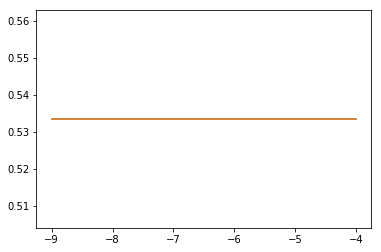

In [38]:
N_val = []
precision = []
recall = []
f1 = []
accs = []
param_range = np.arange(-9,-3)
recipient_val = recipients["word"]["df"]["dev"]
for rate in 10.0**param_range:
    model = train_supervised(input=recipients["word"]["train"], 
                             epoch=50, #tuned 
                             lr=rate, #tuned minimal improvements
                             ws = 5, #default 5
                             wordNgrams=2, #tuned 
                             verbose=2, #default 2
                             minCount=1, #default 1 
                             dim=200)
    N,p,r =  results(*model.test(recipients["word"]["dev"]))
    f1.append(get_F1(p,r))
    N_val.append(N)
    precision.append(p)
    recall.append(r)
    accs.append(get_acc(model, recipient_val))


plt.plot(param_range,f1)
plt.plot(param_range, accs)
param_range[np.argmax(f1)], param_range[np.argmax(accs)]

In [40]:
#best model for sender
recipient_test = recipients["word"]["df"]["test"]
recipient_val = recipients["word"]["df"]["dev"]
recipients["word"]["model"] = train_supervised(input=recipients["word"]["train"], 
                             epoch=50, #tuned 
                             lr=10.0**-4, #tuned minimal improvements
                             ws = 5, #tuned 
                             wordNgrams=1, #tuned 
                             verbose=2, #tuned minimal improvements
                             minCount=1, 
                             dim=200)
print(get_acc(recipients["word"]["model"], recipient_test), get_acc(recipients["word"]["model"], recipient_val))
#insert model tested on fair frame here

0.5282108708760445 0.5334459110176792


# Vizulations and Examples

In [44]:


def get_prob_df(df, model):
    label = df.gender
    label.name = "true_label"
    pred_label = df.text.apply(lambda x: model.predict(x)[0][0][9].capitalize())
    pred_label.name = "predicted_label"
    prob_label = df.text.apply(lambda x: model.predict(x)[1][0])
    prob_label.name = "prob_of_predicted_label"
    prob_label = prob_label.apply(lambda x: x**(x<1))
    prob_F = abs(1*(pred_label == "M")-prob_label)
    prob_F.name = "prob of F"
    prob_M = abs(1*(pred_label == "F")-prob_label)
    prob_M.name = "prob of M"
    data = [label, pred_label, prob_label, prob_F, prob_M, df.content, df.text]
    return pd.concat(data, axis=1, keys=[s.name for s in data])

def get_results(df_dict, prime_dir):
    for key, level in df_dict.items():
        model = level["model"]
        test = level["df"]["test"]
        fairframe = level["df"]["fairframe"]
        df_dict[key]["results"] ={"test":get_prob_df(test, model),
                                  "fairframe":get_prob_df(fairframe, model)}
        df_dict[key]["results"]["test"].to_csv("%s/%s/test.csv"%(prime_dir, key))
        df_dict[key]["results"]["fairframe"].to_csv("%s/%s/fairframe.csv"%(prime_dir, key))
    return df_dict
senders = get_results(senders, "results/sender")
recipients = get_results(recipients, "results/recipient")

In [42]:
sender_test_pred = get_prob_df(sender_test, sender_model)
recipient_test_pred = get_prob_df(recipient_test, recipient_model)

In [43]:
def get_prob_df_from_txt(filename, model):
    f = open(filename, "r")
    lines =  f.read().split("\n")[:-1]
    f.close()
    labels = [line[9].capitalize() for line in lines]
    labels = pd.Series(labels, name="true_label")
    pred_label = [model.predict(x)[0][0][9].capitalize() for x in lines]
    pred_label = pd.Series(pred_label, name="predicted_label")
    prob_label = [model.predict(x)[1][0]  for x in lines]
    prob_label = pd.Series(prob_label, name="prob_of_predicted_label")
    prob_label = prob_label.apply(lambda x: x**(x<1))
    prob_F = abs(1*(pred_label == "M")-prob_label)
    prob_F.name = "prob of F"
    prob_M = abs(1*(pred_label == "F")-prob_label)
    prob_M.name = "prob of M"
    data = [labels, pred_label, prob_label, prob_F, prob_M]
    return pd.concat(data, axis=1, keys=[s.name for s in data])


In [44]:
sender_fairframe_df = get_prob_df_from_txt(sender["fairframe"], sender_model)
recipient_fairframe_df = get_prob_df_from_txt(recipient["fairframe"], recipient_model)

In [45]:
from sklearn import linear_model, svm, metrics
t

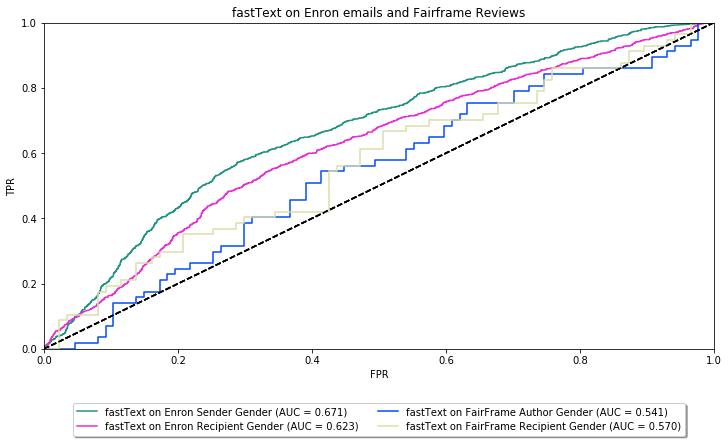

In [46]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
rocplot(1*(sender_test_pred.true_label == "F"),
        sender_test_pred["prob of F"],
        "fastText on Enron Sender Gender")
rocplot(1*(recipient_test_pred.true_label == "F"),
        recipient_test_pred["prob of F"],
        "fastText on Enron Recipient Gender")
rocplot(1*(sender_fairframe_df.true_label == "F"),
        sender_fairframe_df["prob of F"],
        "fastText on FairFrame Author Gender")
rocplot(1*(recipient_fairframe_df.true_label == "F"),
        recipient_fairframe_df["prob of F"],
        "fastText on FairFrame Recipient Gender")
plt.title("fastText on Enron emails and Fairframe Reviews")
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
lgd = ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True,
                shadow = True, ncol = 2, prop = {'size':10})
plt.savefig("ROC.png")

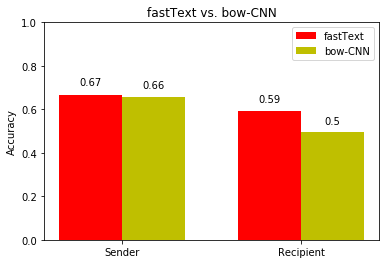

In [47]:
#based off of matplotlib demo
#https://matplotlib.org/examples/api/barchart_demo.html

N = 2
fastText_accs = (get_acc(sender_model, sender_test), get_acc(recipient_model, recipient_test))
CNN_accs =(0.6551501453019051, 0.4963673350770125) # these values were taken from the bowCNN notebook
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, fastText_accs, width, color='r')


rects2 = ax.bar(ind + width, CNN_accs, width, color='y')
plt.ylim([0.0, 1.0])
# add some text for labels, title and axes ticks
ax.set_ylabel('Accuracy')
ax.set_title('fastText vs. bow-CNN')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Sender', 'Recipient'))

ax.legend((rects1[0], rects2[0]), ('fastText', 'bow-CNN'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%s' % round(height,2),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
#uncomment to save figure
#plt.savefig("bars_comparison.png")

# Example Sentences

In [48]:
import random
def worst_example_finder(df, pred_df, num_examples = 10, p =0.7):
    choose_from = pred_df[:][pred_df.true_label != pred_df.predicted_label]
    emails = df.content[pred_df.true_label != pred_df.predicted_label]
    chosen = emails[choose_from["prob_of_predicted_label"] >= p]
    probs = choose_from["prob_of_predicted_label"][choose_from["prob_of_predicted_label"] >= p]
    labels = choose_from["predicted_label"][choose_from["prob_of_predicted_label"] >= p]
    for i in range(num_examples):
        rando = int(random.randint(0,len(chosen)))
        print(chosen.iloc[rando]+" \n (With probability %s as %s) \n" %(probs.iloc[rando], labels.iloc[rando]) )
    

In [49]:
worst_example_finder(sender_test, sender_test_pred, 5, .9)

it's an aquired taste 
 (With probability 1.0 as M) 

Tom,  Thanks. If dummyname have an extra copy, please send dummyname one.  dummyname 
 (With probability 0.9738147258758545 as M) 

Jeremy, I need to have dummyname to calc all books on a minibook level.  Please let dummyname  know if dummyname need dummyname further information.  Also, how my proposed index book  move coming along?  Thanks. DG    dummydate 
 (With probability 0.9486370086669922 as F) 

Those look good, thanks.  dummyname 
 (With probability 0.9544158577919006 as M) 

Shirley,  Pleae, invite Clayton.  dummyname 
 (With probability 0.9985066652297974 as F) 



In [37]:
def best_example_finder(df, pred_df, num_examples = 10, p = 0.7):
    choose_from = pred_df[:][pred_df.true_label == pred_df.predicted_label]
    emails = df.content[pred_df.true_label == pred_df.predicted_label]
    chosen = emails[choose_from["prob_of_predicted_label"] >= p]
    probs = choose_from["prob_of_predicted_label"][choose_from["prob_of_predicted_label"] >= p]
    labels = choose_from["predicted_label"][choose_from["prob_of_predicted_label"] >= p]
    for i in range(num_examples):
        rando = int(random.randint(0,len(chosen)))
        print(chosen.iloc[rando]+" \n (With probability %s as %s) \n" %(probs.iloc[rando], labels.iloc[rando]) )

In [50]:
best_example_finder(sender_test, sender_test_pred, 5, 1)

pls print.  thanks df 
 (With probability 1.0 as M) 

I extended dummyname deal.  D 
 (With probability 1.0 as M) 

Ava, have dummyname taken dummyname of this?  Thanks. Lynn 
 (With probability 1.0 as M) 

Jerk       	 	 
 (With probability 1.0 as M) 

My details to dummyname and Sharron... 
 (With probability 1.0 as M) 



### Not normalized input

### Normalized input

### Load existing test

### Predictions